In [179]:
import numpy as np
import math
np.set_printoptions(suppress=True)  # 禁用科学计数
import pandas as pd
import matplotlib.pyplot as plt

In [180]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
data.head()  # 前5行数据

,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [181]:
X = data.iloc[:,:4]
Y = data.iloc[:,4]
Y =Y.replace("Iris-setosa",0)
Y =Y.replace("Iris-versicolor",1)
Y =Y.replace("Iris-virginica",2)
X=X.values
Y=Y.values
Y
#iris-setosa, Iris-versicolor, iris-virginica
model_accuracy = [] #储存各模型的精度

In [182]:
# 计算信息熵
def calculate_entropy(y):
    log2 = math.log2
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy

In [183]:
# 定义树的节点
class DecisionNode():
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i          
        self.threshold = threshold         
        self.value = value                 
        self.true_branch = true_branch     
        self.false_branch = false_branch

In [184]:
def divide_on_feature(X, feature_i, threshold):
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])

In [185]:
# 超类
class DecisionTree(object):
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  #根节点
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        # 计算值 如果是分类问题就是信息增益，回归问题就基尼指数
        self._impurity_calculation = None
        self._leaf_value_calculation = None #计算叶子
        self.one_dim = None
        self.loss = loss

    def fit(self, X, y, loss=None):
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """
        递归求解树
        """

        largest_impurity = 0
        best_criteria = None
        best_sets = None
        
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # 计算每一个特征的增益值
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                for threshold in unique_values:
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)
                    
                    if len(Xy1) > 0 and len(Xy2) > 0:
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # 计算增益值
                        impurity = self._impurity_calculation(y, y1, y2)

                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],  
                                "lefty": Xy1[:, n_features:],   
                                "rightX": Xy2[:, :n_features],  
                                "righty": Xy2[:, n_features:]   
                                }

        if largest_impurity > self.min_impurity:
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)
        
        # 计算节点的目标值
        leaf_value = self._leaf_value_calculation(y)
        
        
        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """
        预测
        """

        if tree is None:
            tree = self.root

        if tree.value is not None:
            return tree.value

        feature_value = x[tree.feature_i]

        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        return self.predict_value(x, branch)

    def predict(self, X):
        y_pred = []
        for x in X:
            y_pred.append(self.predict_value(x))
        return y_pred

In [186]:
class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # 计算信息增益
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * calculate_entropy(y1) - (1 - p) * calculate_entropy(y2)

        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # 投票决定当前的节点为哪一个类
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)

In [206]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
accuracies =[]
for i in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)
    clf = ClassificationTree()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    accuracies.append(accuracy)

In [188]:
accuracies_mean = np.mean(accuracies)
accuracies_var = np.var(accuracies)
accuracies_std = np.std(accuracies)
print("平均值为：%.4f" % accuracies_mean)
print("方差为：%.4f" % accuracies_var)
print("标准差为:%.4f" % accuracies_std)
model_accuracy.append(accuracies_mean)

平均值为：0.9300
方差为：0.0004
标准差为:0.0208


In [189]:
#上面为决策树对iris数据集的预测

In [190]:
def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance
class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # 使用方差缩减
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

In [191]:
class GradientBoosting(object):
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression
        
        self.loss = SquareLoss()
        if not self.regression:
            self.loss = CrossEntropy()

        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth)
            self.trees.append(tree)


    def fit(self, X, y):
        y_pred = np.full(np.shape(y), np.mean(y, axis=0))
        for i in range(self.n_estimators):
            gradient = self.loss.gradient(y, y_pred)
            self.trees[i].fit(X, gradient)
            update = self.trees[i].predict(X)
            # Update y prediction
            y_pred -= np.multiply(self.learning_rate, update)


    def predict(self, X):
        y_pred = np.array([])
        for tree in self.trees:
            update = tree.predict(X)
            update = np.multiply(self.learning_rate, update)
            y_pred = -update if not y_pred.any() else y_pred - update

        if not self.regression:
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            y_pred = np.argmax(y_pred, axis=1)
        return y_pred

In [192]:
class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0
# 如果是分类模型
class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)

In [193]:
class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0
class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

In [194]:
class GradientBoostingClassifier(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=2, debug=False):
        super(GradientBoostingClassifier, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_info_gain,
            max_depth=max_depth,
            regression=False)

    def fit(self, X, y):
        y = to_categorical(y)
        super(GradientBoostingClassifier, self).fit(X, y)

In [195]:
def to_categorical(x, n_col=None):
    """ One-hot encoding of nominal values """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

In [196]:
from sklearn import datasets
from sklearn.metrics import accuracy_score

accuracies =[]
for i in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    accuracies.append(accuracy)
accuracies_mean = np.mean(accuracies)
accuracies_var = np.var(accuracies)
accuracies_std = np.std(accuracies)
print("平均值为：%.4f" % accuracies_mean)
print("方差为：%.4f" % accuracies_var)
print("标准差为:%.4f" % accuracies_std)
model_accuracy.append(accuracies_mean)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


平均值为：0.9367
方差为：0.0013
标准差为:0.0356


In [197]:
#以上为GBDT决策树

In [198]:
from sklearn.preprocessing import normalize
def eucliDist(A,B):
    return np.sqrt(sum(np.power((A - B), 2)))
#计算欧式距离

In [199]:
class KNN(object):
    def __init__(self,k=5):
        self.k = 5
    def _vote(self,neighbours):
        counts = np.bincount(neighbours[:, 1].astype('int'))   #np.bincount返回值中的每个bin，给出了它的索引值在x中出现的次数
        return counts.argmax()
    def predict(self, X_test, X_train, y_train):
        y_pred = np.empty(X_test.shape[0])
        # 对每一个test进行循环
        for i,test in enumerate(X_test):  #enumerate 返回 enumerate(枚举) 对象
            neighbours = np.empty((X_train.shape[0],2))
            # 对每一个train进行计算
            for j, train in enumerate(X_train):
                dis = eucliDist(train,test)
                label = y_train[j]
                neighbours[j] = [dis,label]
            k_nearest_neighbors = neighbours[neighbours[:,0].argsort()][:self.k]
            label = self._vote(k_nearest_neighbors)
            y_pred[i] = label
        return y_pred

In [200]:
X = normalize(X)
accuracies =[]
for i in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)
    clf = KNN(k=5)
    y_pred = clf.predict(X_test, X_train, y_train)
    accuracy = accuracy_score(y_pred, y_test)
    accuracies.append(accuracy)
accuracies_mean = np.mean(accuracies)
accuracies_var = np.var(accuracies)
accuracies_std = np.std(accuracies)
print("平均值为：%.4f" % accuracies_mean)
print("方差为：%.4f" % accuracies_var)
print("标准差为:%.4f" % accuracies_std)
model_accuracy.append(accuracies_mean)

平均值为：0.9717
方差为：0.0006
标准差为:0.0236


In [201]:
#以上为使用KNN方法

In [202]:
class NaiveBayes():   
    """The Gaussian Naive Bayes classifier. """
    def fit(self, X, y):
        
        """
        X [shape,features]
        y [shape,label]
        """
        
        self.X, self.y = X, y
        self.classes = np.unique(y)
        self.parameters = []
        # 计算每一个类别的每一个特征的方差和均值
        for i, c in enumerate(self.classes):
            X_where_c = X[np.where(y == c)]
            self.parameters.append([])
            # 计算每一个特征
            for j in range(X.shape[1]):
                col = X_where_c[:, j] #列
                parameters = {"mean": col.mean(), "var": col.var()} #求方差 与 均值
                self.parameters[i].append(parameters)
    
    def _calculate_likelihood(self, mean, var, x):
        """ 计算高斯概率密度 输入均值 和 方差"""
        eps = 1e-4 # Added in denominator to prevent division by zero
        coeff = 1.0 / math.sqrt(2.0 * math.pi * var + eps)
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * var + eps)))
        return coeff * exponent
    def _calculate_prior(self, c):
        """ 计算先验概率 """
        X_where_c = self.X[np.where(self.y == c)]
        n_class_instances = X_where_c.shape[0]
        n_total_instances = self.X.shape[0]
        return n_class_instances / n_total_instances
    
    def _classify(self, sample):
        posteriors = []
        for i, c in enumerate(self.classes):
            # 计算每一个类别的先验概率 p(y=c)=?
            posterior = self._calculate_prior(c)
            
            for j, params in enumerate(self.parameters[i]):
                # 提取每一个类别下的特征值的方差 以及 均值
                sample_feature = sample[j]
                # 计算高斯密度
                likelihood = self._calculate_likelihood(params["mean"], params["var"], sample_feature)
                posterior *= likelihood
            posteriors.append(posterior)
        # 求最大概率对应的类别
        index_of_max = np.argmax(posteriors)
        return self.classes[index_of_max]
    def predict(self, X):
        y_pred = []
        for sample in X:
            y = self._classify(sample)
            y_pred.append(y)
        return y_pred

In [203]:
X = normalize(X)
accuracies =[]
for i in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)
    clf = NaiveBayes()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_pred,y_test)
    accuracies.append(accuracy)
accuracies_mean = np.mean(accuracies)
accuracies_var = np.var(accuracies)
accuracies_std = np.std(accuracies)
print("平均值为：%.4f" % accuracies_mean)
print("方差为：%.4f" % accuracies_var)
print("标准差为:%.4f" % accuracies_std)
model_accuracy.append(accuracies_mean)

平均值为：0.9650
方差为：0.0003
标准差为:0.0174


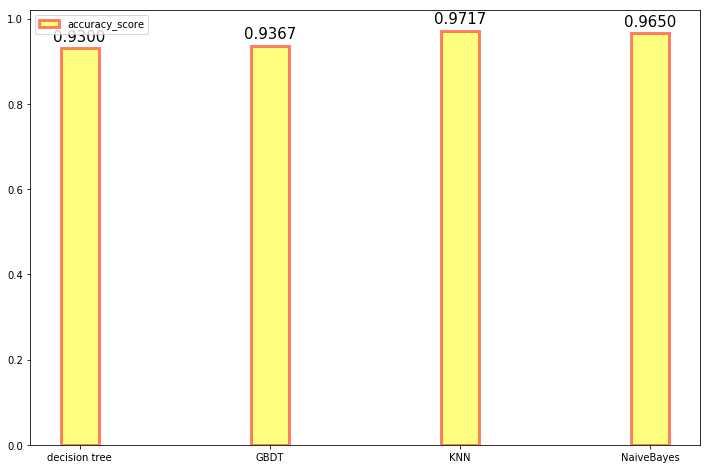

In [204]:
num_cols = ['decision tree', 'GBDT', 'KNN', 'NaiveBayes']
#num_cols = ['decision', 'random forest']
plt.figure(figsize=(12,8))
plt.bar(num_cols, model_accuracy, alpha=0.5, width=0.2, color='yellow', edgecolor='red', label='accuracy_score', lw=3)
plt.legend(loc='upper left')
for a, b in zip(num_cols, model_accuracy):
    plt.text(a, b + 0.01, '%.4f'%b, ha='center', va='bottom', fontsize=15)
plt.show()